Robust MPC: Simulation with linearized rocket system

In [1]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import sys, os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

In [2]:
from LandMPC.MPCControl_z import MPCControl_z
from src.rocket import Rocket
from src.pos_rocket_vis import *

# Require ipympl
%matplotlib widget 

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

# Rocket setup
Ts  = 1/20
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
rocket.mass = 1.7 # Do not change!!!

# Visualization setup
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1

sim_time = 10.0  # simulation length in seconds
x0 = np.array([0, 0, 0, 0, 0, np.deg2rad(30), 0, 0, 0, 3, 2, 10])
x_ref = np.array([0.]*9 + [1., 0., 3.])
xs, us = rocket.trim(x_ref)
print("Linearization around a steady state:")
print("x_ref = ", x_ref)
print("xs = ", xs)
print("us = ", us)
sys = rocket.linearize_sys(xs, us)
A, B = sys.A, sys.B


H = 5.0
mpc = MPCControl_z(A, B, xs, us, Ts, H)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Linearization around a steady state:
x_ref =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
xs =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
us =  [ 0.          0.         56.66666667  0.        ]


AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=199, step=2), IntSlider(value=0…

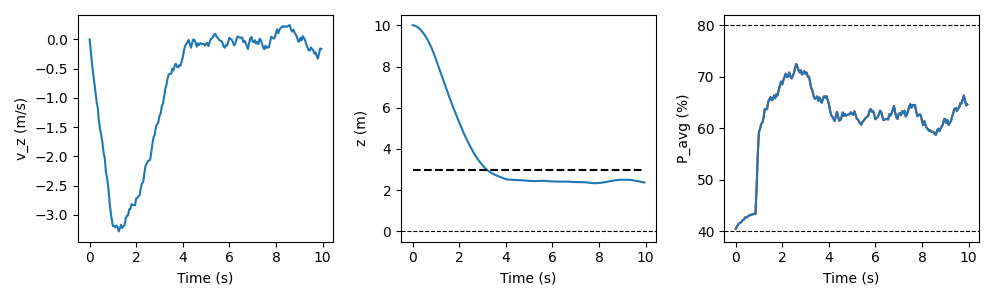

In [3]:
t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='random')
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=199, step=2), IntSlider(value=0…

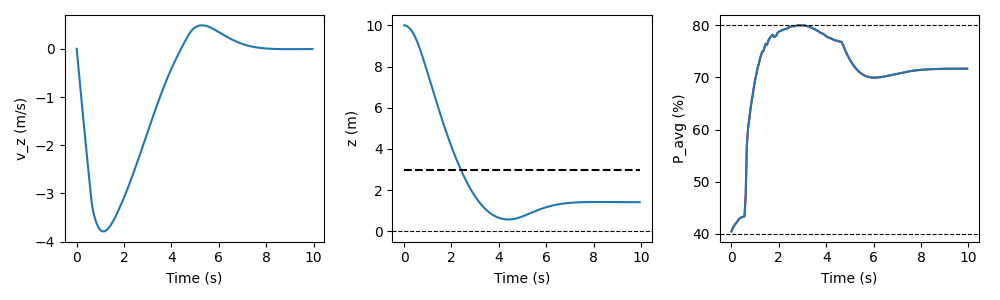

In [4]:
t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='extreme')
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')

<>:31: SyntaxWarning: invalid escape sequence '\o'
<>:32: SyntaxWarning: invalid escape sequence '\o'
<>:38: SyntaxWarning: invalid escape sequence '\o'
<>:39: SyntaxWarning: invalid escape sequence '\o'
<>:31: SyntaxWarning: invalid escape sequence '\o'
<>:32: SyntaxWarning: invalid escape sequence '\o'
<>:38: SyntaxWarning: invalid escape sequence '\o'
<>:39: SyntaxWarning: invalid escape sequence '\o'
C:\Users\natha\AppData\Local\Temp\ipykernel_20792\1750592685.py:31: SyntaxWarning: invalid escape sequence '\o'
  ax[0].set_xlabel('Velocity Error ($v_z - \overline{v}_z$)', fontsize=10)
C:\Users\natha\AppData\Local\Temp\ipykernel_20792\1750592685.py:32: SyntaxWarning: invalid escape sequence '\o'
  ax[0].set_ylabel('Position Error ($z - \overline{z}$)', fontsize=10)
C:\Users\natha\AppData\Local\Temp\ipykernel_20792\1750592685.py:38: SyntaxWarning: invalid escape sequence '\o'
  ax[1].set_xlabel('Nominal Velocity ($\overline{v}_z$)', fontsize=10)
C:\Users\natha\AppData\Local\Temp\ipyke


=== Deliverable 6.1: Tightened Input Constraints ===
Tightened Delta Input (U~): [-8.1253, 4.7817] N
Absolute Thrust Limits:     [48.54, 61.45] N
(Physical Hard Limits are [40.00, 80.00] N)


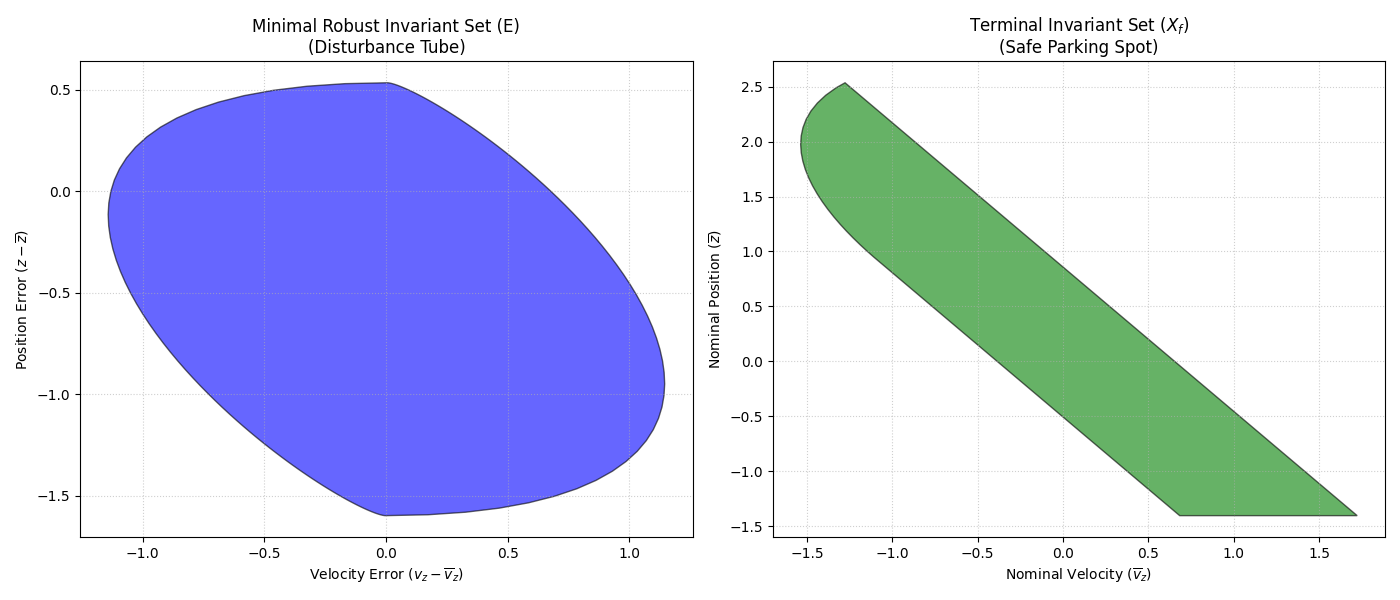

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# --- 1. CALCULATE AND PRINT VERTICES OF TIGHTENED CONSTRAINT (U_bar) ---
print("\n=== Deliverable 6.1: Tightened Input Constraints ===")

# Force computation of vertices (mpt4py lazy evaluation)
_ = mpc.U_bar.Vrep

# Get min and max delta values from the vertices
v_min = np.min(mpc.U_bar.V, axis=0)
v_max = np.max(mpc.U_bar.V, axis=0)

# 1. Delta Thrust
print(f"Tightened Delta Input (U~): [{v_min[0]:.4f}, {v_max[0]:.4f}] N")

# 2. Absolute Thrust
# FIX: Use index 0 because mpc.us is already sliced to size 1 for this subsystem
abs_min = mpc.us[0] + v_min[0]
abs_max = mpc.us[0] + v_max[0]

print(f"Absolute Thrust Limits:     [{abs_min:.2f}, {abs_max:.2f}] N")
print(f"(Physical Hard Limits are [40.00, 80.00] N)")


# --- 2. PLOT INVARIANT SETS (E and Xf) ---
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot Minimal Robust Invariant Set (E)
mpc.E.plot(ax=ax[0], color='b', alpha=0.6, linestyle='-')
ax[0].set_title('Minimal Robust Invariant Set (E)\n(Disturbance Tube)', fontsize=12)
ax[0].set_xlabel('Velocity Error ($v_z - \overline{v}_z$)', fontsize=10)
ax[0].set_ylabel('Position Error ($z - \overline{z}$)', fontsize=10)
ax[0].grid(True, linestyle=':', alpha=0.6)

# Plot Terminal Invariant Set (Xf)
mpc.Xf.plot(ax=ax[1], color='g', alpha=0.6, linestyle='-')
ax[1].set_title('Terminal Invariant Set ($X_f$)\n(Safe Parking Spot)', fontsize=12)
ax[1].set_xlabel('Nominal Velocity ($\overline{v}_z$)', fontsize=10)
ax[1].set_ylabel('Nominal Position ($\overline{z}$)', fontsize=10)
ax[1].grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()


=== Deliverable 6.1: Tightened Input Constraints ===
Tightened Delta Input (U~): [-8.1253, 4.7817] N
Absolute Thrust Limits:     [48.54, 61.45] N
(Physical Hard Limits are [40.00, 80.00] N)


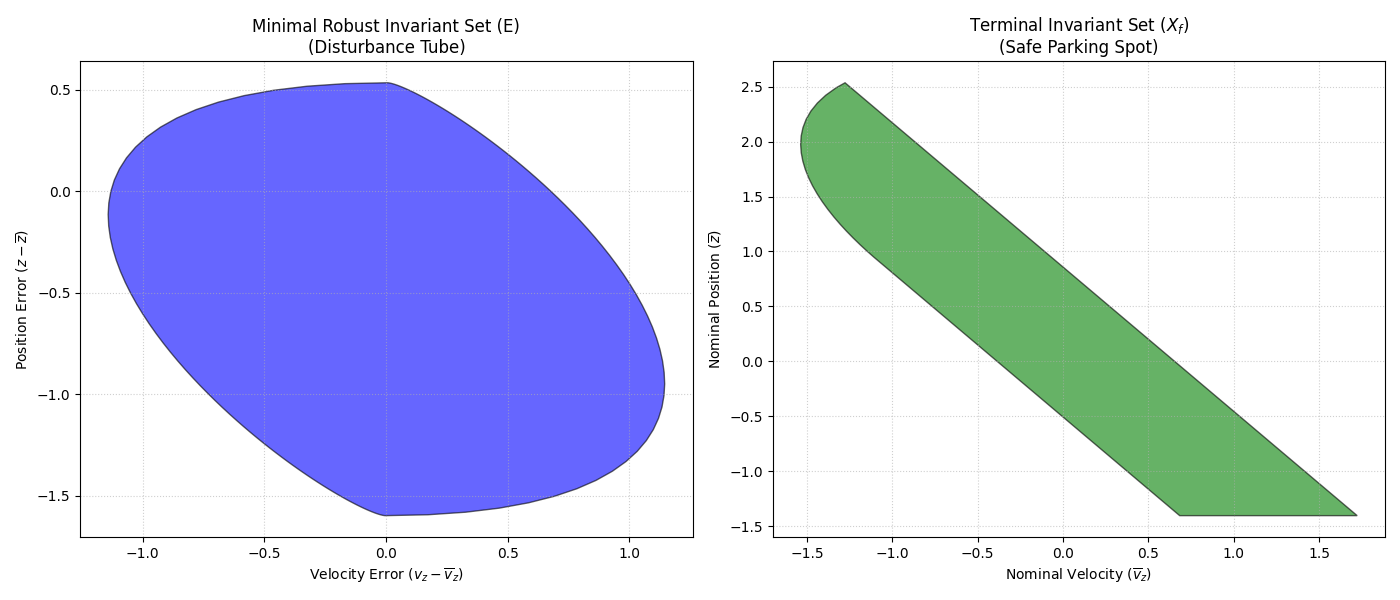

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. CALCULATE AND PRINT VERTICES OF TIGHTENED CONSTRAINT (U_bar) ---
print("\n=== Deliverable 6.1: Tightened Input Constraints ===")

# Force computation of vertices (mpt4py lazy evaluation)
_ = mpc.U_bar.Vrep

# Get min and max delta values from the vertices
v_min = np.min(mpc.U_bar.V, axis=0)
v_max = np.max(mpc.U_bar.V, axis=0)

# 1. Delta Thrust
print(f"Tightened Delta Input (U~): [{v_min[0]:.4f}, {v_max[0]:.4f}] N")

# 2. Absolute Thrust
# FIX: Use index [0] because mpc.us is only size 1 (thrust only)
abs_min = mpc.us[0] + v_min[0]
abs_max = mpc.us[0] + v_max[0]

print(f"Absolute Thrust Limits:     [{abs_min:.2f}, {abs_max:.2f}] N")


# --- 2. PLOT INVARIANT SETS (E and Xf) ---
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot Minimal Robust Invariant Set (E)
mpc.E.plot(ax=ax[0], color='b', alpha=0.6, linestyle='-')
ax[0].set_title('Minimal Robust Invariant Set (E)\n(Disturbance Tube)', fontsize=12)
# FIX: Added r'' to handle LaTeX backslashes
ax[0].set_xlabel(r'Velocity Error ($v_z - \overline{v}_z$)', fontsize=10)
ax[0].set_ylabel(r'Position Error ($z - \overline{z}$)', fontsize=10)
ax[0].grid(True, linestyle=':', alpha=0.6)

# Plot Terminal Invariant Set (Xf)
mpc.Xf.plot(ax=ax[1], color='g', alpha=0.6, linestyle='-')
ax[1].set_title('Terminal Invariant Set ($X_f$)\n(Safe Parking Spot)', fontsize=12)
# FIX: Added r'' to handle LaTeX backslashes
ax[1].set_xlabel(r'Nominal Velocity ($\overline{v}_z$)', fontsize=10)
ax[1].set_ylabel(r'Nominal Position ($\overline{z}$)', fontsize=10)
ax[1].grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()